In [1]:
import pandas as pd
import cupy as cp  # Optional, only if you need GPU-based NumPy ops
import os
import numpy as np
import tensorflow as tf
from cuml.preprocessing import MinMaxScaler
from cuml.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2025-04-07 10:30:49.332762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 10:30:49.344555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744002049.358662  413263 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744002049.362710  413263 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744002049.373415  413263 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# --- CONFIG ---
CLEANED_PATH = "/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/backend/data_processing/financial_reports/cleaned"
SEQ_LENGTH = 5
TARGET_COL = "totalrevenue"


In [3]:
# --- STEP 1: Load and merge company data using pandas ---
companies = list(set([f.split("_")[0] for f in os.listdir(CLEANED_PATH)]))
company_data = {}

for company in companies:
    try:
        bs = pd.read_csv(f"{CLEANED_PATH}/{company}_balance_sheet_cleaned.csv")
        is_ = pd.read_csv(f"{CLEANED_PATH}/{company}_income_statement_cleaned.csv")
        cf = pd.read_csv(f"{CLEANED_PATH}/{company}_cash_flow_cleaned.csv")

        for df in [bs, is_, cf]:
            df["year"] = pd.to_datetime(df["year"], errors='coerce').dt.year

        df = bs.merge(is_, on=["year", "symbol", "reportedcurrency"], how="inner")
        df = df.merge(cf, on=["year", "symbol", "reportedcurrency"], how="inner")
        df = df[df["year"].isin(list(range(2009, 2025)))]
        company_data[company] = df.reset_index(drop=True)
        print(f"✅ {company} loaded")
    except Exception as e:
        print(f"⚠️ {company} failed: {e}")

✅ NVDA loaded
✅ AAPL loaded
✅ TSLA loaded
✅ IBM loaded
✅ META loaded
✅ MSFT loaded
✅ V loaded
✅ JPM loaded
✅ AMZN loaded
✅ GOOGL loaded


In [4]:
# --- STEP 2: Preprocessing & Sequence Creation ---
scaler = MinMaxScaler()
X_all, y_all = [], []

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

for company, df in company_data.items():
    try:
        df = df.dropna()
        df["year"] = df["year"].astype("int32")

        numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
        numeric_cols = [c for c in numeric_cols if c != "year"]

        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        if TARGET_COL not in df.columns:
            continue

        target_data = df[TARGET_COL].to_numpy().reshape(-1, 1)
        X, y = create_sequences(target_data, SEQ_LENGTH)

        X_all.append(X)
        y_all.append(y)
        print(f"✅ Sequences created for {company}")
    except Exception as e:
        print(f"⚠️ {company} failed during sequence processing: {e}")

✅ Sequences created for NVDA
✅ Sequences created for AAPL
✅ Sequences created for TSLA
✅ Sequences created for IBM
✅ Sequences created for META
✅ Sequences created for MSFT
✅ Sequences created for V
✅ Sequences created for JPM
✅ Sequences created for AMZN
✅ Sequences created for GOOGL


In [5]:
# --- STEP 3: Combine and Split ---
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

print(f"✅ Final Dataset: X_train: {X_train.shape}, X_test: {X_test.shape}")

✅ Final Dataset: X_train: (76, 5, 1), X_test: (18, 5, 1)


In [6]:
# --- STEP 4: LSTM Model (TensorFlow GPU or CPU) ---
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

W0000 00:00:1744002098.481462  413263 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0994 - val_loss: 0.0143
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0887 - val_loss: 0.0067
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0470 - val_loss: 0.0232
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381 - val_loss: 0.0232
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0408 - val_loss: 0.0158
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0423 - val_loss: 0.0170
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0417 - val_loss: 0.0116
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0325 - val_loss: 0.0141
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0397 - val_loss: 0.0162
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0385 - val_loss: 0.0134
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0313 - val_loss: 0.0086
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0388

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
📉 MSE: 0.00
📊 MAE: 0.03
📈 R² Score: 0.8704


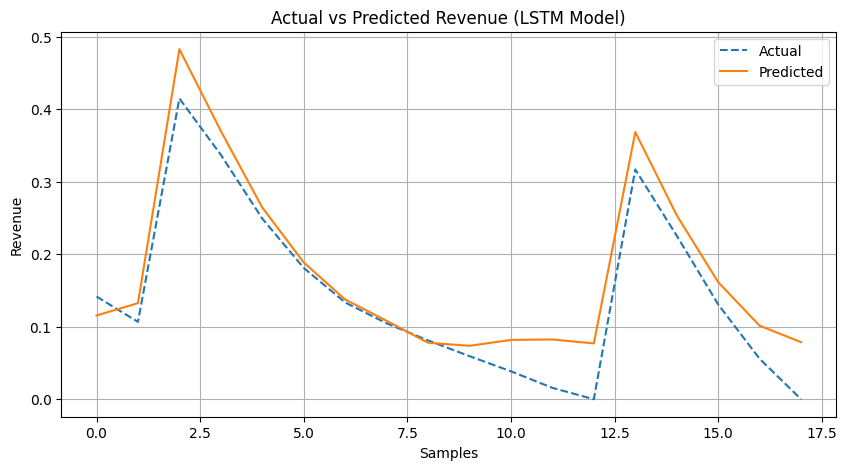

In [7]:
# --- STEP 5: Prediction & Evaluation ---
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 MSE: {mse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")

# --- STEP 6: Plot Results ---
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", linestyle='--')
plt.plot(y_pred, label="Predicted", linestyle='-')
plt.title("Actual vs Predicted Revenue (LSTM Model)")
plt.xlabel("Samples")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()